## Analysis of PyTorch vs. sklearn logistic regression results

In [33]:
import os
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

First, analyze the aggregate results, using accuracy/AUROC/AUPRC. If the implementation is correct the results should be close to the same.

In [78]:
# signals = ['signal', 'shuffled']
# seeds = range(1, 6)
signals = ['signal', 'shuffled']
seeds = [1, 2, 3]

In [79]:
results_dir = os.path.abspath('./pytorch_results')
results_df = None
columns = ['imp', 'dataset', 'metric', 'fold', 'score', 'signal', 'seed']

for signal in signals:
    for seed in seeds:
        parsed_result = {c: [] for c in columns}
        cv_results_file = os.path.join(results_dir,
                                       'cv_results_{}_{}.pkl'.format(signal, seed))
        with open(cv_results_file, 'rb') as f:
            cv_results = pkl.load(f)
        num_folds = len(list(cv_results.values())[0])
        for fold in range(num_folds):
            for k, vs in cv_results.items():
                imp, dataset, metric = k.split('_')
                parsed_result['imp'].append(imp)
                parsed_result['dataset'].append(dataset)
                parsed_result['metric'].append(metric)
                parsed_result['fold'].append(fold)
                parsed_result['score'].append(vs[fold])
                parsed_result['signal'].append(signal)
                parsed_result['seed'].append(seed)
        df = pd.DataFrame(parsed_result)
        if results_df is None:
            results_df = df
        else:
            results_df = pd.concat((results_df, df))

results_df.head(n=5)

,imp,dataset,metric,fold,score,signal,seed
0,sklearn,train,auroc,0,0.937014,signal,1
1,sklearn,train,aupr,0,0.918063,signal,1
2,sklearn,train,acc,0,0.874321,signal,1
3,sklearn,tune,auroc,0,0.910794,signal,1
4,sklearn,tune,aupr,0,0.861877,signal,1


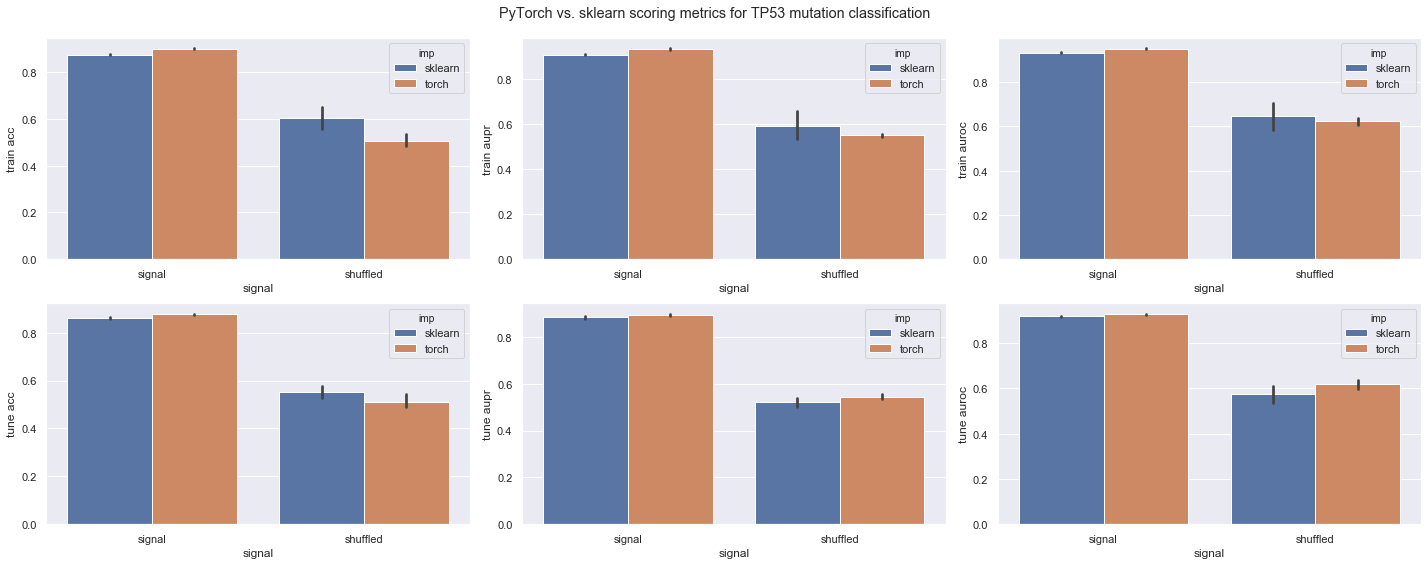

In [80]:
metrics = np.unique(results_df['metric'].values)
datasets = np.unique(results_df['dataset'].values)
sns.set()
fig, axarr = plt.subplots(len(datasets), len(metrics))
fig.set_figheight(8)
fig.set_figwidth(20)

for i, dataset in enumerate(datasets):
    for j, metric in enumerate(metrics):
        ax = axarr[i, j]
        plot_df = results_df[(results_df['metric'] == metric) & (results_df['dataset'] == dataset)]
        sns.barplot(data=plot_df, x='signal', y='score', hue='imp', ax=ax)
        ax.set_ylabel('{} {}'.format(dataset, metric))
plt.tight_layout()
fig.suptitle('PyTorch vs. sklearn scoring metrics for TP53 mutation classification')
fig.subplots_adjust(top=0.925)

Results look fairly similar between implementations.

Next, we want to compare the sparsity of the models. If the PyTorch L1 penalty is working correctly, the models should have a similar number of zero coefficients.

In [81]:
columns = ['imp', 'signal', 'seed', 'fold', 'sparsity']
sparsity = []
for signal in signals:
    for seed in seeds:
        sk_coefs_file = os.path.join(results_dir,
                                     'sklearn_coefs_{}_{}.tsv.gz'.format(
                                       signal, seed))
        sk_coefs_df = pd.read_csv(sk_coefs_file, sep='\t').sort_values('feature')
        torch_coefs_file = os.path.join(results_dir,
                                        'torch_coefs_{}_{}.tsv.gz'.format(
                                          signal, seed))
        torch_coefs_df = pd.read_csv(torch_coefs_file, sep='\t').sort_values('feature')
        folds = np.unique(sk_coefs_df['fold'].values)
        for fold in folds:
            sk_coefs = sk_coefs_df[sk_coefs_df['fold'] == fold]['weight'].values
            torch_coefs = torch_coefs_df[torch_coefs_df['fold'] == fold]['weight'].values
            sk_sparsity = np.count_nonzero(sk_coefs==0) / sk_coefs.shape[0]
            torch_sparsity = np.count_nonzero(torch_coefs==0) / torch_coefs.shape[0]
            sparsity.append(['sklearn', signal, seed, fold, sk_sparsity])
            sparsity.append(['torch', signal, seed, fold, torch_sparsity])
        if signal == 'signal' and seed == 2:
            sk_plot_coefs = sk_coefs
            torch_plot_coefs = torch_coefs
            
sparsity_df = pd.DataFrame(sparsity, columns=columns)
sparsity_df.head()

,imp,signal,seed,fold,sparsity
0,sklearn,signal,1,1,0.976190
1,torch,signal,1,1,0.000000
2,sklearn,signal,1,2,0.974819
3,torch,signal,1,2,0.000000
4,sklearn,signal,1,3,0.972201


Text(0.5, 1.0, 'Coefficient sparsity for PyTorch vs sklearn')

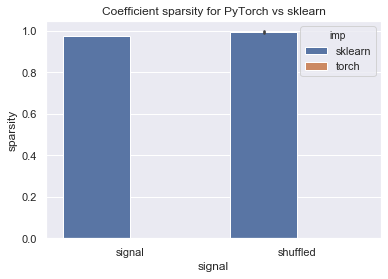

In [82]:
sns.set()
sns.barplot(data=sparsity_df, x='signal', y='sparsity', hue='imp')
plt.title('Coefficient sparsity for PyTorch vs sklearn')

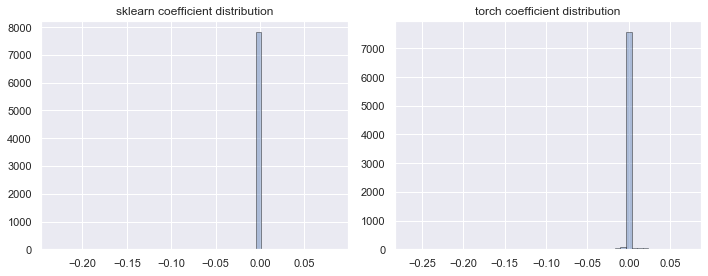

In [83]:
sns.set()
fig, axarr = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.set_figheight(4)
for i, coefs in enumerate([sk_plot_coefs, torch_plot_coefs]):
    ax = axarr[i]
    sns.distplot(coefs, kde=False, hist_kws={'edgecolor': 'black'}, ax=ax)
    ax.set_title('{} coefficient distribution'.format('sklearn' if i==0 else 'torch'))
plt.tight_layout()

So, coefficients for the PyTorch model don't appear to be sparse at all, but the coefficient distribution looks reasonably similar to the distribution of scikit-learn coefficients. Weird!

Why is this? I claim that my naive PyTorch implementation will almost never actually zero out the coefficients, although it shrinks many of them to almost zero.

It turns out that shrinking coefficients to exactly zero (and keeping them there during the optimization procedure) makes sense in theory, but numerically it's a fairly difficult problem. See, for instance, [this paper](https://www.aclweb.org/anthology/P09-1054.pdf) which contains a nice explanation of why it's hard to implement. Scikit-learn implements the algorithm in that paper, which is why it is able to produce coefficients that are exactly 0.

Luckily, for our purposes there's not much difference between exactly 0 and almost 0.

Text(0.5, 1.0, 'Coefficient sparsity for PyTorch vs sklearn, with threshold')

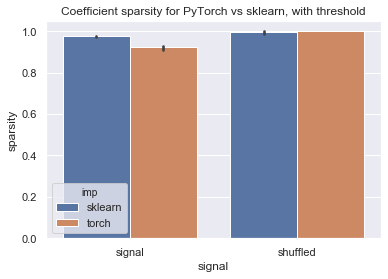

In [84]:
columns = ['imp', 'signal', 'seed', 'fold', 'sparsity']
sparsity = []
for signal in signals:
    for seed in seeds:
        sk_coefs_file = os.path.join(results_dir,
                                     'sklearn_coefs_{}_{}.tsv.gz'.format(
                                       signal, seed))
        sk_coefs_df = pd.read_csv(sk_coefs_file, sep='\t').sort_values('feature')
        torch_coefs_file = os.path.join(results_dir,
                                        'torch_coefs_{}_{}.tsv.gz'.format(
                                          signal, seed))
        torch_coefs_df = pd.read_csv(torch_coefs_file, sep='\t').sort_values('feature')
        folds = np.unique(sk_coefs_df['fold'].values)
        for fold in folds:
            sk_coefs = sk_coefs_df[sk_coefs_df['fold'] == fold]['weight'].values
            torch_coefs = torch_coefs_df[torch_coefs_df['fold'] == fold]['weight'].values
            # for pytorch, to avoid dealing with numerical error near 0, just pick a
            # (somewhat arbitrary) threshold and set all smaller coefficients to 0
            close_to_zero = (np.abs(torch_coefs) < (np.abs(torch_coefs).max() / 1000))
            torch_coefs[close_to_zero] = 0
            sk_sparsity = np.count_nonzero(sk_coefs==0) / sk_coefs.shape[0]
            torch_sparsity = np.count_nonzero(torch_coefs==0) / torch_coefs.shape[0]
            sparsity.append(['sklearn', signal, seed, fold, sk_sparsity])
            sparsity.append(['torch', signal, seed, fold, torch_sparsity])
            
sparsity_df = pd.DataFrame(sparsity, columns=columns)
sns.set()
sns.barplot(data=sparsity_df, x='signal', y='sparsity', hue='imp')
plt.title('Coefficient sparsity for PyTorch vs sklearn, with threshold')

Great! This looks fairly similar. But how different are the nonzero coefficients that the methods are finding? Is there any similarity to the signal that the methods are using to predict mutation status?

In [85]:
# TODO: some of this should go in a utilities file (functions, etc)

torch_coefs_folds, sk_coefs_folds = {}, {}
# extract coefficients by method/seed/fold
for signal in ['signal', 'shuffled']:
    torch_coefs_folds[signal] = {}
    sk_coefs_folds[signal] = {}
    for seed in seeds:
        torch_coefs_folds[signal][seed] = {}
        sk_coefs_folds[signal][seed] = {}
        sk_coefs_file = os.path.join(results_dir,
                                     'sklearn_coefs_{}_{}.tsv.gz'.format(signal, seed))
        sk_coefs_df = pd.read_csv(sk_coefs_file, sep='\t').sort_values('feature')
        torch_coefs_file = os.path.join(results_dir,
                                        'torch_coefs_{}_{}.tsv.gz'.format(signal, seed))
        torch_coefs_df = pd.read_csv(torch_coefs_file, sep='\t').sort_values('feature')
        folds = np.unique(sk_coefs_df['fold'].values)
        for fold in folds:
            sk_coefs = sk_coefs_df[sk_coefs_df['fold'] == fold]['weight'].values
            sk_genes = sk_coefs_df[sk_coefs_df['fold'] == fold]['feature'].values
            torch_coefs = torch_coefs_df[torch_coefs_df['fold'] == fold]['weight'].values
            torch_genes = torch_coefs_df[torch_coefs_df['fold'] == fold]['feature'].values
            # for pytorch, to avoid dealing with numerical error near 0, just pick a
            # (somewhat arbitrary) threshold and set all smaller coefficients to 0
            close_to_zero = (np.abs(torch_coefs) < (np.abs(torch_coefs).max() / 1000))
            torch_coefs[close_to_zero] = 0
            torch_coefs_folds[signal][seed][fold] = (torch_coefs, torch_genes)
            sk_coefs_folds[signal][seed][fold] = (sk_coefs, sk_genes)
        
# jaccard similarity (works with unequal length strings)
def compute_jaccard(v1, v2):
    intersection = v1.intersection(v2)
    union = v1.union(v2)
    return len(intersection) / len(union)
        
# get inter-method similarity on same seed/fold
inter_method_sims = []
for seed in seeds:
    for fold in folds:
        sk_coefs = sk_coefs_folds['signal'][seed][fold][0]
        sk_genes = sk_coefs_folds['signal'][seed][fold][1]
        sk_nz_coefs = (sk_coefs != 0)
        sk_nz_genes = sk_genes[sk_nz_coefs]
        torch_coefs = torch_coefs_folds['signal'][seed][fold][0]
        torch_genes = torch_coefs_folds['signal'][seed][fold][1]
        torch_nz_coefs = (torch_coefs != 0)
        torch_nz_genes = torch_genes[torch_nz_coefs]
        inter_method_sims.append(compute_jaccard(set(sk_nz_genes), set(torch_nz_genes)))
        
import itertools as it

intra_method_sims_sk = []
intra_method_sims_torch = []

# get intra-method similarity within seeds, between folds
# should be an "upper bound" of sorts for inter-method similarity
# but is it actually?
for seed in seeds:
    for f1, f2 in it.combinations(folds, 2):
        
        # first for scikit-learn
        sk_coefs_f1 = sk_coefs_folds['signal'][seed][f1][0]
        sk_genes_f1 = sk_coefs_folds['signal'][seed][f1][1]
        sk_coefs_f2 = sk_coefs_folds['signal'][seed][f2][0]
        sk_genes_f2 = sk_coefs_folds['signal'][seed][f2][1]
        sk_nz_coefs_f1 = (sk_coefs_f1 != 0)
        sk_nz_genes_f1 = sk_genes_f1[sk_nz_coefs_f1]
        sk_nz_coefs_f2 = (sk_coefs_f2 != 0)
        sk_nz_genes_f2 = sk_genes_f2[sk_nz_coefs_f2]
        intra_method_sims_sk.append(compute_jaccard(set(sk_nz_genes_f1), set(sk_nz_genes_f2)))
        
        # then for torch
        torch_coefs_f1 = torch_coefs_folds['signal'][seed][f1][0]
        torch_genes_f1 = torch_coefs_folds['signal'][seed][f1][1]
        torch_coefs_f2 = torch_coefs_folds['signal'][seed][f2][0]
        torch_genes_f2 = torch_coefs_folds['signal'][seed][f2][1]
        torch_nz_coefs_f1 = (torch_coefs_f1 != 0)
        torch_nz_genes_f1 = torch_genes_f1[torch_nz_coefs_f1]
        torch_nz_coefs_f2 = (torch_coefs_f2 != 0)
        torch_nz_genes_f2 = torch_genes_f2[torch_nz_coefs_f2]
        intra_method_sims_torch.append(compute_jaccard(set(torch_nz_genes_f1), set(torch_nz_genes_f2)))
        
print(inter_method_sims)
print(intra_method_sims_sk)
print(intra_method_sims_torch)

# get inter-method similarity on same seed/fold, shuffled
inter_method_sims_shuffled = []
for seed in seeds:
    for fold in folds:
        sk_coefs = sk_coefs_folds['shuffled'][seed][fold][0]
        sk_genes = sk_coefs_folds['shuffled'][seed][fold][1]
        sk_nz_coefs = (sk_coefs != 0)
        sk_nz_genes = sk_genes[sk_nz_coefs]
        torch_coefs = torch_coefs_folds['shuffled'][seed][fold][0]
        torch_genes = torch_coefs_folds['shuffled'][seed][fold][1]
        torch_nz_coefs = (torch_coefs != 0)
        torch_nz_genes = torch_genes[torch_nz_coefs]
        inter_method_sims_shuffled.append(compute_jaccard(set(sk_nz_genes), set(torch_nz_genes)))
        
import itertools as it

intra_method_sims_shuffled_sk = []
intra_method_sims_shuffled_torch = []

# get intra-method similarity within seeds, between folds
# should be an "upper bound" of sorts for inter-method similarity
# but is it actually?
for seed in seeds:
    for f1, f2 in it.combinations(folds, 2):
        
        # first for scikit-learn
        sk_coefs_f1 = sk_coefs_folds['shuffled'][seed][f1][0]
        sk_genes_f1 = sk_coefs_folds['shuffled'][seed][f1][1]
        sk_coefs_f2 = sk_coefs_folds['shuffled'][seed][f2][0]
        sk_genes_f2 = sk_coefs_folds['shuffled'][seed][f2][1]
        sk_nz_coefs_f1 = (sk_coefs_f1 != 0)
        sk_nz_genes_f1 = sk_genes_f1[sk_nz_coefs_f1]
        sk_nz_coefs_f2 = (sk_coefs_f2 != 0)
        sk_nz_genes_f2 = sk_genes_f2[sk_nz_coefs_f2]
        intra_method_sims_shuffled_sk.append(compute_jaccard(set(sk_nz_genes_f1), set(sk_nz_genes_f2)))
        
        # then for torch
        torch_coefs_f1 = torch_coefs_folds['shuffled'][seed][f1][0]
        torch_genes_f1 = torch_coefs_folds['shuffled'][seed][f1][1]
        torch_coefs_f2 = torch_coefs_folds['shuffled'][seed][f2][0]
        torch_genes_f2 = torch_coefs_folds['shuffled'][seed][f2][1]
        torch_nz_coefs_f1 = (torch_coefs_f1 != 0)
        torch_nz_genes_f1 = torch_genes_f1[torch_nz_coefs_f1]
        torch_nz_coefs_f2 = (torch_coefs_f2 != 0)
        torch_nz_genes_f2 = torch_genes_f2[torch_nz_coefs_f2]
        intra_method_sims_shuffled_torch.append(compute_jaccard(set(torch_nz_genes_f1), set(torch_nz_genes_f2)))
        
print(inter_method_sims)
print(intra_method_sims_sk)
print(intra_method_sims_torch)

print(inter_method_sims_shuffled)
print(intra_method_sims_shuffled_sk)
print(intra_method_sims_shuffled_torch)

[0.012430939226519336, 0.009873060648801129, 0.01608910891089109, 0.012690355329949238, 0.014884979702300407, 0.01485148514851485, 0.021709633649932156, 0.013360739979445015, 0.016098484848484848]
[0.25961538461538464, 0.25835866261398177, 0.22832369942196531, 0.26959247648902823, 0.2709677419354839, 0.2616822429906542, 0.2485207100591716, 0.23809523809523808, 0.2469879518072289]
[0.04451038575667656, 0.0410958904109589, 0.04806786050895382, 0.040983606557377046, 0.07841409691629955, 0.04672057502246182, 0.04689984101748808, 0.054599850411368736, 0.0661049902786779]
[0.012430939226519336, 0.009873060648801129, 0.01608910891089109, 0.012690355329949238, 0.014884979702300407, 0.01485148514851485, 0.021709633649932156, 0.013360739979445015, 0.016098484848484848]
[0.25961538461538464, 0.25835866261398177, 0.22832369942196531, 0.26959247648902823, 0.2709677419354839, 0.2616822429906542, 0.2485207100591716, 0.23809523809523808, 0.2469879518072289]
[0.04451038575667656, 0.0410958904109589, 0.

Text(0, 0.5, 'Jaccard similarity')

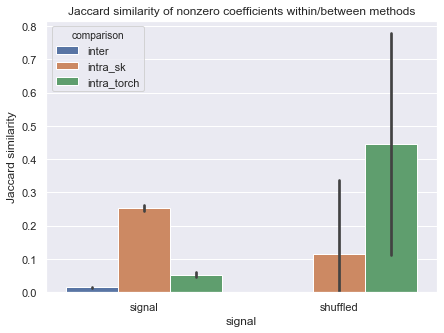

In [95]:
# assemble into dataframe
df_list = []
for j in inter_method_sims:
    df_list.append([j, 'inter', 'signal'])
for j in intra_method_sims_sk:
    df_list.append([j, 'intra_sk', 'signal'])
for j in intra_method_sims_torch:
    df_list.append([j, 'intra_torch', 'signal'])
for j in inter_method_sims_shuffled:
    df_list.append([j, 'inter', 'shuffled'])
for j in intra_method_sims_shuffled_sk:
    df_list.append([j, 'intra_sk', 'shuffled'])
for j in intra_method_sims_shuffled_torch:
    df_list.append([j, 'intra_torch', 'shuffled'])

jaccard_df = pd.DataFrame(df_list, columns=['jaccard', 'comparison', 'signal'])
sns.set(rc={'figure.figsize': (7, 5)})
sns.barplot(data=jaccard_df, x='signal', y='jaccard', hue='comparison')
plt.title('Jaccard similarity of nonzero coefficients within/between methods')
plt.ylabel('Jaccard similarity')


### __Key to the above comparisons that doesn't require the code:__

* "Inter-method" comparison: compare sklearn vs. torch coefficients for the same random seeds/CV folds
* "Intra-method" comparison: compare sklearn vs. sklearn (or torch vs. torch) coefficients for the same random seeds across CV folds
* signal vs. shuffled: shuffled scrambles expression between genes (should be no predictive signal)

### **Takeaways:**

Coefficients are not very stable at all between methods. Despite having similar predictive performance and similar sparsity, the nonzero coefficients found by PyTorch and sklearn have almost no overlap.

Coefficients are somewhat more stable within methods across different splits of the data. sklearn seems to be more stable than PyTorch in this regard, but both are better than the intra-method comparison.

Shuffled results are weird (you can't see it here but the Jaccard index is mostly either 0 or 1, I would expect to see mostly 0 but who knows)
